In [97]:
import hopsworks
import pandas as pd
import numpy as np 
import joblib
from datetime import datetime
import dataframe_image as dfi
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error

In [22]:
import sys 
import os
os.chdir('/'.join(os.getcwd().split('/')[:-1]))
from wave_model.LinReg import LinReg

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Multiple projects found. 

	 (1) SMDL_A01
	 (2) kompot

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194711
Connected. Call `.close()` to terminate connection gracefully.


In [23]:
mr = project.get_model_registry()
model = mr.get_model('wave_reg',version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/wave_reg.pkl")

Connected. Call `.close()` to terminate connection gracefully.


In [37]:
fv = fs.get_feature_view('merged_swells_huntington', version=5)
df = fv.get_batch_data(
    #start_time = "20240101",
    #end_time = "20240106",
    read_options={"use_hive": True})

Finished: Reading data from Hopsworks, using Hive (1.50s) 


In [38]:
y_pred = model.predict_labels(df)

In [40]:
df

,height,period,direction
0,0.20,13.5,14.0
1,0.19,15.5,11.0
2,0.20,14.6,10.0
3,0.35,4.0,82.0
4,1.01,15.6,88.0
5,0.19,12.7,13.0
6,0.20,14.1,11.0
7,0.18,16.0,13.0
8,1.18,16.1,89.0
9,0.56,11.3,80.0


In [39]:
y_pred

array(['Fair', 'Poor To Fair', 'Poor To Fair', 'Fair To Good',
       'Poor To Fair', 'Fair', 'Poor To Fair', 'Poor To Fair', 'Poor',
       'Fair', 'Fair', 'Poor To Fair', 'Fair', 'Fair', 'Poor To Fair',
       'Fair', 'Fair To Good', 'Fair', 'Fair'], dtype='<U32')

In [51]:
fg = fs.get_feature_group(name="merged_swells_huntington", version=4)
df = fg.read()[-df.shape[0]:]
df.shape

Finished: Reading data from Hopsworks, using ArrowFlight (0.83s) 


(19, 11)

In [52]:
labels = df['quality']

In [63]:
monitor_fg = fs.get_or_create_feature_group(name="wave_monitor_predictions",
                                            version=1,
                                            primary_key=["datetime"],
                                            description="Outcome Monitoring"
                                            )

now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
data = {
    'prediction': y_pred,
    'label': labels,
    'prediction_at': [now for _ in range(len(y_pred))],
    'datetime':df['hits_at'].apply(str).str.slice(0,13)
    }
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df, write_options={"wait_for_job" : False})

history_df = monitor_fg.read(read_options={"use_hive": True} )
# Add our prediction to the history, as the history_df won't have it - 
# the insertion was done asynchronously, so it will take ~1 min to land on App
history_df = pd.concat([history_df, monitor_df])

Uploading Dataframe: 0.00% |          | Rows 0/19 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wave_monitor_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/194711/jobs/named/wave_monitor_predictions_1_offline_fg_materialization/executions


Finished: Reading data from Hopsworks, using Hive (0.95s) 


In [73]:
df_export = pd.DataFrame({'prediction':history_df['prediction'],
 'label':history_df['label'],
 'abs_err':np.abs(model.encode(history_df['label']).reshape(-1) - model.encode(history_df['prediction'])),
 'datetime':history_df['datetime'],
 'prediction_at':history_df['prediction_at']})
df_export.tail()

,prediction,label,abs_err,datetime,prediction_at
14,Poor To Fair,Fair To Good,2,2024-01-04 06,"01/06/2024, 01:32:51"
15,Fair,Fair,0,2024-01-05 07,"01/06/2024, 01:32:51"
16,Fair To Good,Fair,1,2024-01-04 12,"01/06/2024, 01:32:51"
17,Fair,Poor,2,2024-01-03 12,"01/06/2024, 01:32:51"
18,Fair,Fair To Good,1,2024-01-05 12,"01/06/2024, 01:32:51"


In [75]:
df_recent = df_export.tail(5)
dfi.export(df_recent, './wave_df_recent.png', table_conversion = 'matplotlib')
dataset_api = project.get_dataset_api()
dataset_api.upload("./wave_df_recent.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/45882 elapsed<00:00 remaining<?

'Resources/images/wave_df_recent.png'

In [98]:
predictions = model.encode(history_df.tail(10)['prediction'])
labels = model.encode(history_df.tail(10)['label'])
mae = mean_absolute_error(labels,predictions)

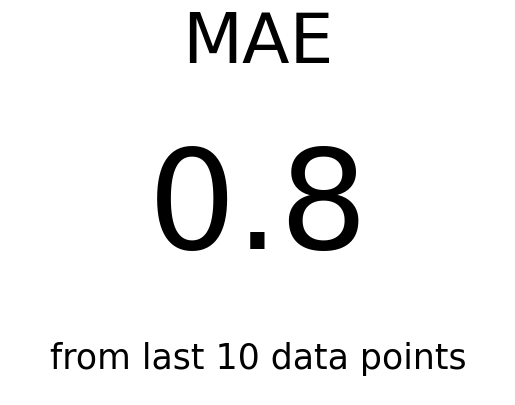

In [105]:
fig,ax = plt.subplots()
ax.text(0.5,0.9,'MAE',fontsize=50,ha='center')
ax.text(0.5,0.5,mae,fontsize=100,va='center', ha='center')
ax.text(0.5,0.1,'from last 10 data points',fontsize=25,va='center', ha='center')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.savefig('wave_mae_recent')

In [106]:
dataset_api.upload("./wave_mae_recent.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/20341 elapsed<00:00 remaining<?

'Resources/images/wave_mae_recent.png'